In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [4]:
data = pd.read_csv('~/Machine Learning/NLP/language-translation-model/dataset/fra-eng/fra.tsv', delimiter='\t')
data.head()

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [38]:
data = data.iloc[:55000, :]

english = data['english']
french = data['french']

In [39]:
print("Length of english sentence:", len(english))
print("Length of french sentence:", len(french))

Length of english sentence: 55000
Length of french sentence: 55000


In [40]:
english = [s.translate(str.maketrans('', '', string.punctuation)) for s in english]
french = [s.translate(str.maketrans('', '', string.punctuation)) for s in french]
print('After removing punctuation')
print('English word is: ', english[100])
print('-'*20)
print('French word is: ', french[100])

After removing punctuation
English word is:  Come in
--------------------
French word is:  Entre 


In [41]:
english = [s.lower() if isinstance(s, str) else s for s in english]
french = [s.lower() if isinstance(s, str) else s for s in french]

print('Convert all examples to lowercase')
print('English word is: ', english[100])
print('-'*20)
print('French word is: ', french[100])

Convert all examples to lowercase
English word is:  come in
--------------------
French word is:  entre 


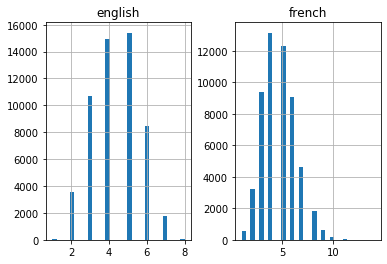

In [42]:
eng_l = [len(s.split()) for s in english]
fre_l = [len(s.split()) for s in french]

length_df = pd.DataFrame({'english': eng_l, 'french': fre_l})
length_df.hist(bins=30)
plt.show()

In [57]:
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, RepeatVector, Dropout, Bidirectional, Flatten

In [44]:
def tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

In [45]:
english_tokenizer = tokenizer(english)
french_tokenizer = tokenizer(french)

In [46]:
word_index_english = english_tokenizer.word_index
word_index_french = french_tokenizer.word_index

eng_vocab_size = len(word_index_english) + 1
fre_vocab_size = len(word_index_french) + 1

print("Size of english vocab:", len(word_index_english))
print("Size of french vocab:", len(word_index_french))

Size of english vocab: 6908
Size of french vocab: 15743


In [47]:
max_len_eng = max(eng_l)
max_len_fre = max(fre_l)

print("Max length of english sentence:", max_len_eng)
print("Max length of french sentence:", max_len_fre)

Max length of english sentence: 8
Max length of french sentence: 14


In [48]:
english = pd.Series(english).to_frame('english')
french = pd.Series(french).to_frame('french')

dummy_df = pd.concat([english, french], axis=1)
train, test = train_test_split(dummy_df, test_size=0.1, random_state=42)

train_english = train.english.values
train_french = train.french.values

test_english = test.english.values
test_french = test.french.values

In [49]:
def encode_sequences(tokenizer, length, text):
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    return sequences

In [50]:
eng_seq = encode_sequences(english_tokenizer, max_len_eng, train_english)
fre_seq = encode_sequences(french_tokenizer, max_len_fre, train_french)

# test_english = encode_sequences(english_tokenizer, max_len_eng, test_english)
test_french = encode_sequences(french_tokenizer, max_len_fre, test_french)

In [53]:
print("english sentences have the same length :", max_len_eng)
print(eng_seq[15])
print(eng_seq[78])
print('-'*20)
print("french sentences have the same length :", max_len_fre)
print(fre_seq[86])
print(fre_seq[145])

english sentences have the same length : 8
[3205    5  980 6052    0    0    0    0]
[ 12 339 102   0   0   0   0   0]
--------------------
french sentences have the same length : 14
[   26   309     3   766    12 13565     0     0     0     0     0     0
     0     0]
[ 19  21 324 112   0   0   0   0   0   0   0   0   0   0]


In [54]:
def nmt_model(in_vocab_size, out_vocab_size, in_timestep, out_timestep, units):
    model = Sequential()
    model.add(Embedding(in_vocab_size, units, input_length=in_timestep, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4)))
    model.add(Dropout(0.3))
    model.add(RepeatVector(out_timestep))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Dense(out_vocab_size, activation="softmax"))
    return model

In [55]:
model = nmt_model(fre_vocab_size, eng_vocab_size, max_len_fre, max_len_eng, 128)

In [59]:
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=rms, metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 256)           4030464   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1050624   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 512)            1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
dense (Dense)                (None, 8, 6909)           3

In [61]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [63]:
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [65]:
eng_seq = eng_seq.reshape(eng_seq.shape[0], eng_seq.shape[1], 1)
history = model.fit(fre_seq, eng_seq, batch_size=1024, epochs=10, verbose=1, validation_split=0.05, shuffle=True, callbacks=[checkpoint])

Epoch 1/10
46/46 [==============================] - 150s 3s/step - loss: 3.6767 - accuracy: 0.4756 - val_loss: 3.1382 - val_accuracy: 0.5162

Epoch 00001: val_accuracy improved from -inf to 0.51621, saving model to weights-improvement.hdf5
Epoch 2/10
46/46 [==============================] - 151s 3s/step - loss: 2.9422 - accuracy: 0.5411 - val_loss: 2.6382 - val_accuracy: 0.5788

Epoch 00002: val_accuracy improved from 0.51621 to 0.57884, saving model to weights-improvement.hdf5
Epoch 3/10
46/46 [==============================] - 151s 3s/step - loss: 2.4854 - accuracy: 0.5901 - val_loss: 2.3187 - val_accuracy: 0.6099

Epoch 00003: val_accuracy improved from 0.57884 to 0.60990, saving model to weights-improvement.hdf5
Epoch 4/10
46/46 [==============================] - 151s 3s/step - loss: 2.1575 - accuracy: 0.6213 - val_loss: 2.0538 - val_accuracy: 0.6449

Epoch 00004: val_accuracy improved from 0.60990 to 0.64490, saving model to weights-improvement.hdf5
Epoch 5/10
46/46 [=============

KeyboardInterrupt: 

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
prediction = model.predict_classes(test_french.reshape(test_french.shape[0], test_french.shape[1]))